## Decision Trees and Random Forests
  * **Decision Trees: Classification Trees**
  * **Ensembles make excellent machine learning models**
  * **Ensembles of Decision Trees: Random Forests**

In order to use several state-of-the-art machine learning methods, we need to be able to understand their core component: decision trees.

Decision trees, like logistic regression and support vector machines have been used commonly for machine learning tasks for some time. These models are fairly easy to understand and are the basis of the state-of-the-art model that we will build up to (Random Forests).

Decision trees are especially interesting because they approach the machine learning problem in a way that is quite different from both methods we've used so far.

Lets get all of the imports out of the way for the packages we will be working with today:

In [15]:
#data handling/prediction
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.externals.six import StringIO

#visualization
#3d visualization!
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

Lets get the data we've been working with so far and do our same preprocessing steps:

In [18]:
# Let's use our earlier dataset
kidney_columns = ["age","bp","sg","al","su","rbc","pc","pcc","ba",
                  "bgr","bu","sc","sod","pot","hemo","pcv","wc","rc",
                  "htn","dm","cad","appet","pe","ane","class"]
kidney_data = pd.read_csv("../data/chronic_kidney_disease.csv", names=kidney_columns,na_values="?")
kidney_columns = kidney_columns[:5]+kidney_columns[9:18]+kidney_columns[5:9]+kidney_columns[18:]
kidney_data = kidney_data[kidney_columns]
kidney_data["class"] = (kidney_data["class"]=="ckd").astype(int)

#fill the numeric data
median_per_column = kidney_data[kidney_columns[:14]].apply(lambda x: x.median(),axis=0)
numeric_median_filled = kidney_data[kidney_columns[:14]].fillna(median_per_column,axis=0)

#our 2-feature model, this time for a decision tree
feature_cols = ['bgr',"pcv","hemo"]
X_3dim = numeric_median_filled[feature_cols]
y = kidney_data["class"]

In [19]:
numeric_median_filled.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,138.0,4.4,15.4,44.0,7800.0,5.2
1,7.0,50.0,1.020,4.0,0.0,121.0,18.0,0.8,138.0,4.4,11.3,38.0,6000.0,4.8
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,138.0,4.4,9.6,31.0,7500.0,4.8
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,138.0,4.4,11.6,35.0,7300.0,4.6


This time, let's take a look at our dataset in 3 dimensions, using 3 as opposed to 2 features for building our ML model.

<IPython.core.display.Javascript object>


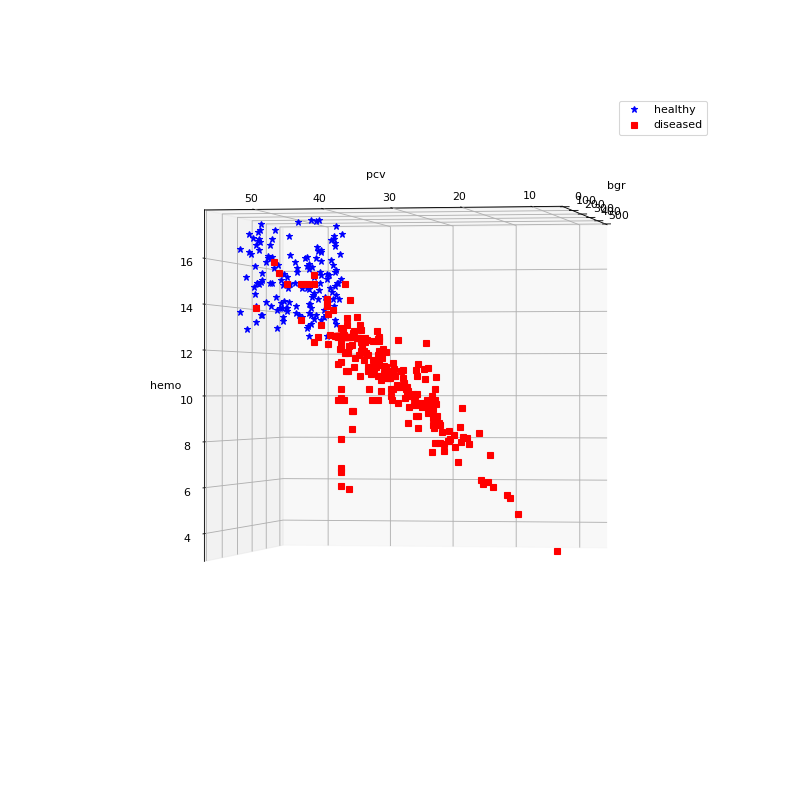

In [38]:
#make the 3d plot movable!
%matplotlib nbagg

# create figure
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')

#add the 2 classes individually
ax.plot3D(X_3dim.values[y.values==0,0], X_3dim.values[y.values==0,1], X_3dim.values[y.values==0,2],'*b',label="healthy")
ax.plot3D(X_3dim.values[y.values==1,0], X_3dim.values[y.values==1,1], X_3dim.values[y.values==1,2],'sr',label="diseased")
#add axis labels and legend
ax.set_xlabel(feature_cols[0])
ax.set_ylabel(feature_cols[1])
ax.set_zlabel(feature_cols[2])
ax.legend()
#must use this to render the plot to screen
plt.show()

Lets build a decision tree model using just these three features. The constraints of the decision tree that we will build are as follows: 
  * Segment the whole space of `bgr`/`pcv`/`hemo` possibilities into distinct regions
  * Use the majority class **class** as the predicted `class` for that combination of `bgr`, `pcv`,`hemo` values for future samples.
  * Intuitively, we want to **maximize** the similarity (or "homogeneity") of `class` within a given region, and **minimize** the similarity of `class` between regions. So, more similar samples within a region, distinct colors across regions.

We will follow some strict rules for segmenting the whole space:
  * You can only use **straight lines** within a single dimension
  * Your lines must either be **vertical or horizontal**.
  * Every line **stops** when it hits an existing line.
  * We are effectively building "rectangular prisms" within this 3-d space.

Before we build our model, lets generate train/test splits of our data:

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X_3dim,y,test_size=.4,random_state=20)

Now lets build our model and check its test error (using **`accuracy_score`**):

In [25]:
decision_tree = DecisionTreeClassifier(max_depth=2)
decision_tree.fit(X_train,y_train)
print("Decision Tree Accuracy:",accuracy_score(y_test,decision_tree.predict(X_test)))

Decision Tree Accuracy: 0.95


Lets visualize our decision tree:

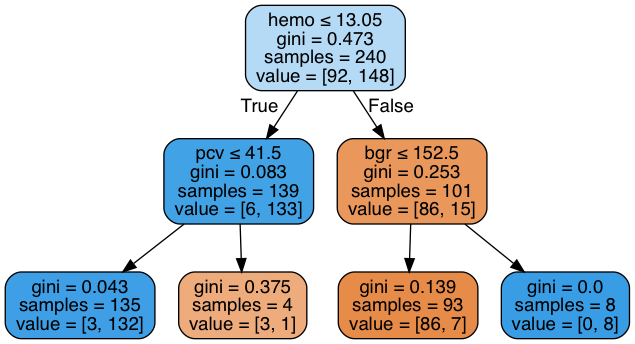

In [26]:
#This allows us to make a decision tree real fast directly in the notebook!
dot_data = StringIO()  
export_graphviz(decision_tree, out_file=dot_data,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

Above is the decision tree created by sklearn and here is how you would read it:

- $R_1$: samples with **less than or equal to 13.05 hemo values and pcv less than or equal to 41.5**, are predicted to not have ckd.
- $R_2$: samples with **less than or equal to 13.05 hemo values and pcv more than 41.5**, are predicted to have ckd.
- $R_3$: samples with **more than 13.05 hemo values and bgr less than or equal to 152.5**, are predicted to have ckd.
- $R_4$: samples with **more than 13.05 hemo values and bgr more than 152.5**, is predicted to have a not have ckd.

These regions are used to make predictions on **out-of-sample data**:

In [28]:
decision_tree.predict(X_test)

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1])

Lets visualize the decision surface in 3d, using z-scored data:

In [40]:
#Zscore to make 3d plotting easier to handle
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #create a scaler object
scaler.fit(numeric_median_filled) #fit the scaler
numeric_scaled = scaler.transform(numeric_median_filled) #transform the data with it
numeric_scaled = pd.DataFrame(numeric_scaled,columns=kidney_columns[:14])
numeric_scaled.head()

X_3dim_scaled = numeric_scaled[feature_cols]

In [50]:
#generate the 3d mesh
plot_step = 0.5
x_min, x_max = X_3dim_scaled.values[:, 0].min() - .5, X_3dim_scaled.values[:, 0].max() + .5
y_min, y_max = X_3dim_scaled.values[:, 1].min() - .5, X_3dim_scaled.values[:, 1].max() + .5
z_min, z_max = X_3dim_scaled.values[:, 2].min() - .5, X_3dim_scaled.values[:, 2].max() + .5
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step),
                        np.arange(z_min,z_max,plot_step))

In [51]:
#train new z-scored decision tree model
X_train_scaled,X_test_scaled,y_train_scaled,y_test_scaled = train_test_split(X_3dim_scaled,y,test_size=.4,random_state=20)

decision_tree = DecisionTreeClassifier(max_depth=2)
decision_tree.fit(X_train_scaled,y_train_scaled)
print("Decision Tree Accuracy:",accuracy_score(y_test_scaled,decision_tree.predict(X_test_scaled)))

Decision Tree Accuracy: 0.95


<IPython.core.display.Javascript object>


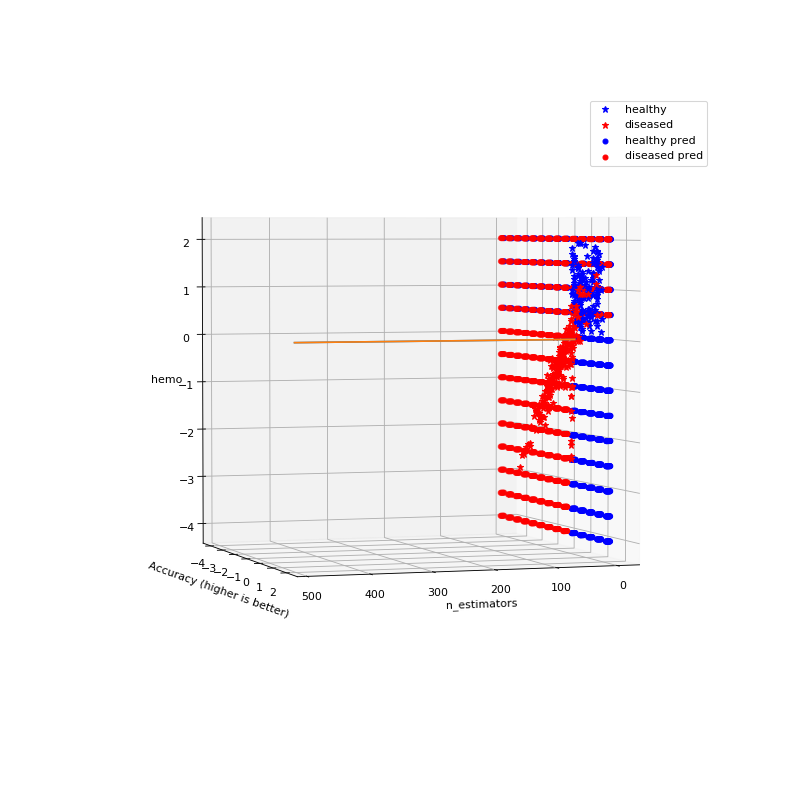

In [58]:
%matplotlib nbagg

#generate meshgrid predictions and plot everything here
Z = decision_tree.predict(np.c_[xx.ravel(), yy.ravel(),zz.ravel()])
Z = Z.reshape(xx.shape)

#make the 3d plot movable!
%matplotlib nbagg

# create figure
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')

#add the 2 classes individually
ax.plot3D(X_3dim_scaled.values[y.values==0,0], X_3dim_scaled.values[y.values==0,1], X_3dim_scaled.values[y.values==0,2],'*b',label="healthy")
ax.plot3D(X_3dim_scaled.values[y.values==1,0], X_3dim_scaled.values[y.values==1,1], X_3dim_scaled.values[y.values==1,2],'*r',label="diseased")
ax.scatter3D(xx[Z==0],yy[Z==0],zz[Z==0],c="blue",label="healthy pred")
ax.scatter3D(xx[Z==1],yy[Z==1],zz[Z==1],c="red",label="diseased pred")
#add axis labels and legend
ax.set_xlabel(feature_cols[0])
ax.set_ylabel(feature_cols[1])
ax.set_zlabel(feature_cols[2])
ax.legend()
#must use this to render the plot to screen
plt.show()

Lets look at the tree again:

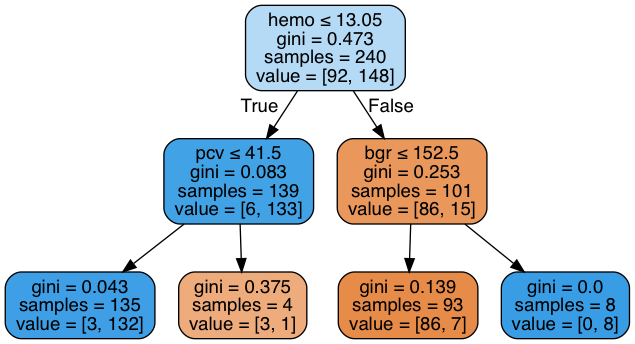

In [29]:
Image(graph.create_png())

### Splitting criteria for classification trees

Common options for the splitting criteria when generating classification trees:
  * **classification error rate:** fraction of training observations in a region that don't belong to the most common class
  - **Gini impurity:** measure of how often a randomly chosen element from the set would be incorrectly labeled if it were  randomly labeled according to the distribution of labels in the subset

### Example of classification error rate

Pretend we are predicting whether someone buys an free-standing house or a condo:
  - At a particular node, there are **30 observations** (home buyers), of whom **10 bought free-standing homes and 20 bought condos**.
  - Since the majority class is **condos**, that's our prediction for all 25 observations, and thus the classification error rate is **10/30 = 33%**.

Our goal in making splits is to **reduce the classification error rate**.

Let's try splitting on income:
  - **Greater than 100k/year:** 8 free-standing and 3 condos, thus the predicted class is free-standing
  - **Less than 100k/year:** 2 free-standing and 17 condos, thus the predicted class is condo
  - Classification error rate after this split would be **5/30 = ~17%**
  
Compare that with a split on purchaser-type:
  - **married:** 4 free-standing and 6 condos, thus the predicted class is condo
  - **unmarried:** 6 free-standing and 14 condos, thus the predicted class is condo
  - Classification error rate after this split would be **10/30 = ~33%** (it didnt change!)

The decision tree algorithm will try **every possible split across all features**, and choose the split that **reduces the error rate the most.**

### Example of Gini impurity

Calculate Gini impurity before making a split:

$$1 - \left(\frac {freestanding} {Total}\right)^2 - \left(\frac {condo} {Total}\right)^2 = 1 - \left(\frac {10} {30}\right)^2 - \left(\frac {20} {30}\right)^2 = 0.44$$

- The **maximum value** of Gini impurity is 0.5, and occurs when the classes are perfectly balanced in a node.
- The **minimum value** of Gini impurity is 0, and occurs when there is only one class represented in a node.
- A node with a lower Gini impurity score is said to be more "pure".

Let's evaluate the split on **income** using Gini index:
$$\text{more than 100k: } 1 - \left(\frac {8} {11}\right)^2 - \left(\frac {3} {11}\right)^2 = 0.40$$
$$\text{less than 100k: } 1 - \left(\frac {2} {19}\right)^2 - \left(\frac {17} {19}\right)^2 = 0.19$$
$$\text{Weighted Average: }  0.40 \left(\frac {11} {30}\right) + 0.19 \left(\frac {19} {30}\right) = 0.27$$

Evaluating the split on **purchaser-type** using Gini impurity:
$$\text{married: } 1 - \left(\frac {4} {10}\right)^2 - \left(\frac {6} {10}\right)^2 = 0.48$$
$$\text{unmarried: } 1 - \left(\frac {6} {20}\right)^2 - \left(\frac {14} {20}\right)^2 = 0.42$$
$$\text{Weighted Average: } 0.48 \left(\frac {10} {30}\right) + 0.42 \left(\frac {20} {30}\right) = 0.44$$

The decision tree algorithm will try **every possible split**, and will choose the split that **reduces the Gini impurity (and thus increases the "node purity") the most.**

### What happens when we grow a tree too deep?

Lets measure testing error as we add depth to our tree:

Decision Tree Train/Test Acc: 0.912 0.944
Decision Tree Train/Test Acc: 0.954 0.950
Decision Tree Train/Test Acc: 0.963 0.950
Decision Tree Train/Test Acc: 0.963 0.950
Decision Tree Train/Test Acc: 0.963 0.950
Decision Tree Train/Test Acc: 0.967 0.950
Decision Tree Train/Test Acc: 0.971 0.950
Decision Tree Train/Test Acc: 0.979 0.938
Decision Tree Train/Test Acc: 0.988 0.938
Decision Tree Train/Test Acc: 0.988 0.938


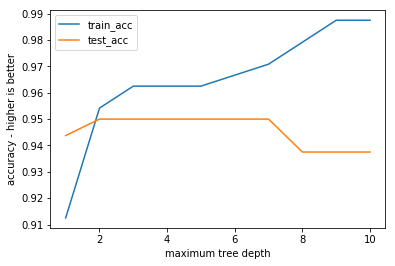

In [36]:
%matplotlib inline
depths = range(1,11)
train_acc, test_acc = [],[]
for depth in depths:
    decision_tree = DecisionTreeClassifier(max_depth=depth,random_state=10)
    decision_tree.fit(X_train,y_train)
    curr_train_acc = accuracy_score(y_train,decision_tree.predict(X_train))
    curr_test_acc = accuracy_score(y_test,decision_tree.predict(X_test))
    print("Decision Tree Train/Test Acc: {:0.3f} {:0.3f}".format(curr_train_acc,curr_test_acc))
    train_acc.append(curr_train_acc)
    test_acc.append(curr_test_acc)
plt.plot(depths,train_acc,label='train_acc')
plt.plot(depths,test_acc,label='test_acc')
plt.xlabel("maximum tree depth")
plt.ylabel("accuracy - higher is better")
plt.legend()
plt.show()

The **training accuracy** continues to go up as the tree size increases (due to overfitting), but the highest **test accuracy** is consistent for a whole range of depths and then proceeds to decrease with depths > 7.

#### Exercise Time!!!
  * Generate a train/test graph like the one above for using ALL of the features in the model. Does it look similar?

In [60]:
# max_depth=2 was best, so fit a tree using that parameter
best_single_tree = DecisionTreeClassifier(max_depth=2, random_state=1)
best_single_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

### Evaluating Feature Importance

The way that we measure the importance of a given feature for a Regression Tree is by computing what is called the [gini importance/coefficient]() of each feature. This measures the normalized total reduction of error when including the given feature.

We can extract the feature importances of any trained tree by extracting its `feature_importances_` property:

In [62]:
pd.DataFrame({'feature':feature_cols, 'importance':best_single_tree.feature_importances_})

,feature,importance
0,bgr,0.135242
1,pcv,0.044178
2,hemo,0.820580


#### Exercise Time !!!
  * Examine the feature importances of your full model. Are they the same as those above? Is the order of the features in terms of their importances the same?

### Understanding a tree diagram

Lets take a look at our best decision tree:

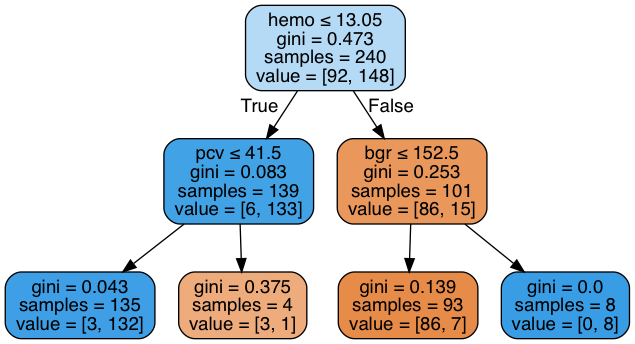

In [63]:
dot_data2 = StringIO()  
export_graphviz(best_single_tree, out_file=dot_data2,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph_best = pydotplus.graph_from_dot_data(dot_data2.getvalue())  
Image(graph_best.create_png())  

How to interpret the internal nodes:

- **rule:** rule used to split that node (go left if true, go right if false)
- **gini:** gini impurity at that node
- **samples:** number of observations in that node before splitting
- **value:** split of negative to positive examples

Reading the leaves (bottom parts of the tree):

- **gini:** gini impurity at that node
- **samples:** number of observations in that node before splitting
- **value:** split of negative to positive examples

## Comparing decision trees with other models
**Advantages of decision trees:**
  * Can be used for regression or classification
  - Can be displayed graphically
  - Highly interpretable
  - Can be specified as a series of rules, and more closely approximate human decision-making than other models
  - Prediction is fast
  - Features don't need scaling
  - Automatically learns feature interactions (they are non-linear models)
  - Tend to ignore irrelevant features (especially when there are lots of features)
  - Because decision trees are non-linear models they will outperform linear models if the relationship between features and response is highly non-linear

**Disadvantages of decision trees:**
  - Performance is (generally) not competitive with the best supervised learning methods
  - Can easily overfit the training data (tuning is required)
  - Small variations in the data can result in a completely different tree (they are high variance models)
  - Recursive binary splitting makes "locally optimal" decisions that may not result in a globally optimal tree
  - Don't tend to work well if the classes are highly unbalanced
  - Don't tend to work well with very small datasets

### Ensembles

Consider:
* instead of building a single model to solve a classification problem, 
* you created **five independent models**, 
* If you combined these models into an "ensemble" and used their **majority vote** as a prediction, 
* and each model was **correct about 70% of the time**. 
* *how often would the ensemble be correct?*

In [64]:
# set a seed for reproducibility
np.random.seed(1234)

# generate 5000 random numbers (between 0 and 1) for each model, representing 5000 observations
mod1 = np.random.rand(5000)
mod2 = np.random.rand(5000)
mod3 = np.random.rand(5000)
mod4 = np.random.rand(5000)
mod5 = np.random.rand(5000)

In [65]:
# each model independently predicts 1 (the "correct response") if random number was at least 0.3
preds1 = np.where(mod1 > 0.3, 1, 0)
preds2 = np.where(mod2 > 0.3, 1, 0)
preds3 = np.where(mod3 > 0.3, 1, 0)
preds4 = np.where(mod4 > 0.3, 1, 0)
preds5 = np.where(mod5 > 0.3, 1, 0)

In [66]:
# print the first 20 predictions from each model
print(preds1[:20])
print(preds2[:20])
print(preds3[:20])
print(preds4[:20])
print(preds5[:20])

[0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1]
[1 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1]
[1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 1]
[1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1]
[1 0 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1]


In [67]:
# average the predictions and then round to 0 or 1
ensemble_preds = np.round((preds1 + preds2 + preds3 + preds4 + preds5)/5.0).astype(int)

# print the ensemble's first 20 predictions
print(ensemble_preds[:20])

[1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1]


In [68]:
# how accurate was each individual model?
print(preds1.mean())
print(preds2.mean())
print(preds3.mean())
print(preds4.mean())
print(preds5.mean())

0.6988
0.6988
0.7
0.7014
0.6982


In [69]:
# how accurate was the ensemble?
print(ensemble_preds.mean())

0.8364


**Ensemble learning (or "ensembling")** is the process of combining several predictive models in order to produce a combined model that is more accurate than any individual model.

- **Regression:** take the average of the predictions
- **Classification:** take a vote and use the most common prediction, or take the average of the predicted probabilities

For ensembling to work well, the models must have the following characteristics:

- **Accurate:** they outperform random guessing
- **Independent:** their predictions are generated using different processes

**The big idea:** If you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when averaging the models.

**Note:** As you add more models to the voting process, the probability of error decreases, which is known as [Condorcet's Jury Theorem](http://en.wikipedia.org/wiki/Condorcet%27s_jury_theorem).

## Ensembling methods

There are two basic methods for ensembling:
- Use a model that ensembles for you (What we will do when we use Random Forests)
- Manually ensemble your individual models

What makes a good "manual ensemble"?
- Different types of models
- Different combinations of features
- Different tuning parameters

Here's an example pipeline that uses ensembling (this is an extreme example):

![Ensemble Kaggle Example](../images/crazy_ensemble_kaggle.png)

### Bagging

The primary weakness of **decision trees** is that they don't tend to have the best predictive accuracy. This is partially due to **high variance**, meaning that different splits in the training data can lead to very different trees.

**Bagging** is a general purpose procedure for reducing the variance of a machine learning method, but is particularly useful for decision trees. Bagging is short for **bootstrap aggregation**, meaning the aggregation of bootstrap samples.

What is a **bootstrap sample**? A random sample with replacement. Here's an example:

In [70]:
# set a seed for reproducibility
np.random.seed(20)

# create an array of 1 through 30
nums = np.arange(1, 31)
print("The original array:",nums)

# sample that array 15 times with replacement
print("The 15 samples:",np.random.choice(a=nums, size=30, replace=True))

The original array: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
The 15 samples: [ 4 27 16 29 27 10 21 12 23  8  3  1 23  9 22 27 27 28 20 17 30  7  7 17
 10  6  8  6  3  7]


**Here's how bagging works for decision trees:**
  1. Grow *b* trees using *b* bootstrap samples from the training data.
  2. Train each tree on its bootstrap sample and make predictions.
  3. Combine the predictions:
    * Average the predictions for **regression trees**
    - Take a majority vote for **classification trees**
    
Keep in mind:
  - **Each bootstrap sample** should be the same size as the original training set.
  - **_b_** should be a large enough value that the error seems to have "stabilized".
  - The trees are **grown deep** so that they have low bias/high variance.
  
Bagging increases predictive accuracy by **reducing the variance**, similar to how cross-validation reduces the variance associated with train/test split (for estimating out-of-sample error) by splitting many times and averaging the results.

### Manually implementing bagged regression trees (with *b*=10)

We are going to implement bagging using our original concrete slump test dataset.

Let's generate our training and testing data, perform bagging on the training data, and compare the resulting RMSE on the test set to our original RMSE:

In [80]:
#train new z-scored decision tree model
X_train,X_test,y_train,y_test = train_test_split(numeric_scaled,y,test_size=.4,random_state=20)


# set a seed for reproducibility
np.random.seed(1234)

# create ten bootstrap samples (will be used to select rows from the DataFrame)

samples = [np.random.choice(a=X_train.shape[0], size=X_train.shape[0], replace=True) for _ in range(1, 11)]
samples

[array([ 47, 211,  38,  53, 204, 116, 152, 143, 177,  23, 233, 154,  30,
        171, 158, 236, 124,  26, 118, 186, 120, 112, 220,  69,  80, 201,
        127, 175,  50,  76,  37,  34, 166, 195, 231, 139, 128, 233,  75,
         80,   3,   2,  19, 140, 193, 203, 115, 107, 209,  14, 199,  60,
        234, 107, 174, 156,  81,  87,  13, 116,  96, 140, 197, 113, 223,
        229, 159,  89,  84,  45,  16,  41,  72, 184, 236,  70, 184,  86,
        172, 218, 211,  47, 177,  18,  85, 174, 226,  37, 109,  38, 135,
        228, 195, 133, 238,  47, 118, 175, 143,  34,  10,  28,   4,  82,
        103,  89,  55, 235,  78, 151, 178,  62, 183,  84, 105,   0, 121,
         98,  90, 161, 114, 121,  21, 199, 196, 119, 231, 209, 180, 192,
        213, 116, 105, 114, 169,   1, 142,   3,  30, 140, 201, 109,  19,
         26, 224,  68, 123, 228,  64, 150, 184, 212, 136, 172, 152, 222,
        233,  15,  72, 130, 144, 107, 130,  79, 195,  46, 226,  57, 183,
         36,  88, 161, 121, 170,   2, 215, 109, 212

In [81]:
X_train.iloc[samples[0], :]

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
50,0.084749,-1.230246,0.421486,-0.686244,-0.380269,-0.719235,1.161625,0.044981,0.475132,-0.098391,-1.453139,-1.359476,1.069295,-1.115855
203,0.202662,0.996444,0.421486,-0.686244,-0.380269,0.824003,0.472438,0.676446,0.475132,0.327468,-1.489997,0.112549,-0.118151,0.074073
80,1.322829,0.254214,-1.421074,-0.686244,-0.380269,-0.173781,0.837302,-0.035064,-0.503681,0.150027,-0.642256,-0.991470,0.435991,-1.115855
64,0.202662,0.254214,-1.421074,-0.686244,-0.380269,0.012472,-0.297830,-0.301880,0.040104,-0.062903,-1.010839,0.112549,-0.118151,0.074073
394,-0.092119,0.254214,0.421486,-0.686244,-0.380269,-0.107262,-0.216749,-0.390819,0.148861,0.150027,0.574068,0.725892,0.475572,-0.163913
249,0.261618,0.996444,-1.421074,2.363728,0.582438,0.411586,5.114316,1.832650,-1.482493,0.682352,-3.480346,-3.690182,-1.147271,-3.138733
294,1.381785,-1.230246,0.421486,-0.686244,-0.380269,-0.466464,-0.135669,-0.408607,-0.286167,0.150027,0.647785,0.112549,0.000594,1.264001
333,-1.683936,0.254214,0.421486,-0.686244,-0.380269,-0.612805,-0.216749,-0.319668,0.475132,-0.204856,1.900968,0.848561,-1.582668,0.907023
365,-1.624979,0.254214,0.421486,-0.686244,-0.380269,-0.692628,-0.216749,-0.355244,0.801403,-0.382298,0.039623,0.112549,0.950551,1.858965
351,-1.330199,0.254214,0.421486,-0.686244,-0.380269,-0.825665,-0.155939,-0.373031,0.148861,-0.453275,1.827251,0.112549,0.633898,-0.044920


In [82]:
# grow each tree deep
treereg = DecisionTreeClassifier(max_depth=None, random_state=123)

# list for storing predicted compressive strength from each tree
predictions = []

# define testing data
X_test_boot = X_test
y_test_boot = y_test

# grow one tree for each bootstrap sample and make predictions on testing data
for sample in samples:
    X_train_boot = X_train.iloc[sample, :]
    y_train_boot = y_train.iloc[sample]
    treereg.fit(X_train_boot, y_train_boot)
    y_pred_boot = treereg.predict(X_test_boot)
    predictions.append(y_pred_boot)

# convert predictions from list to NumPy array
predictions = np.array(predictions)
predictions

array([[1, 0, 0, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 0, 0, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 1, 1]])

In [83]:
# average the predictions
pred_averages = np.mean(predictions, axis=0)
#threshold at 0.5 to get actual votes for each class
final_preds = np.where(pred_averages>=0.5,1,0)

In [84]:
# calculate accuracies for bagged classification trees
print("Bagged Accuracy:",accuracy_score(y_test_boot, final_preds))

#calculate Accuracy for single decision tree with same exact parameters as each tree in the bag
single_tree = DecisionTreeClassifier(max_depth=None, random_state=123)
single_tree.fit(X_train,y_train)
y_pred_single = single_tree.predict(X_test)
print("Single Tree Accuracy:",accuracy_score(y_test_boot, y_pred_single))

Bagged Accuracy: 0.975
Single Tree Accuracy: 0.95625


Pretty cool, huh?

Now let's implement this with much less code using scikit-learn (and lets make 500 trees, instead of 10):

In [94]:
bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True, oob_score=True)#, random_state=1234)
# fit and predict
bag.fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
y_pred_bag

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1])

In [95]:
# calculate Accuracy
print("Bagged Accuracy with 500 trees:",accuracy_score(y_test, y_pred_bag))

Bagged Accuracy with 500 trees: 0.98125


### Estimating out-of-sample error (no cross-validation needed!)

For bagged models, out-of-sample error can be estimated without using **train/test split** or **cross-validation**!

On average, each bagged tree uses about **two-thirds** of the observations. For each tree, the **remaining observations** are called "out-of-bag" observations.

In [88]:
# show the first bootstrap sample
samples[0]

array([ 47, 211,  38,  53, 204, 116, 152, 143, 177,  23, 233, 154,  30,
       171, 158, 236, 124,  26, 118, 186, 120, 112, 220,  69,  80, 201,
       127, 175,  50,  76,  37,  34, 166, 195, 231, 139, 128, 233,  75,
        80,   3,   2,  19, 140, 193, 203, 115, 107, 209,  14, 199,  60,
       234, 107, 174, 156,  81,  87,  13, 116,  96, 140, 197, 113, 223,
       229, 159,  89,  84,  45,  16,  41,  72, 184, 236,  70, 184,  86,
       172, 218, 211,  47, 177,  18,  85, 174, 226,  37, 109,  38, 135,
       228, 195, 133, 238,  47, 118, 175, 143,  34,  10,  28,   4,  82,
       103,  89,  55, 235,  78, 151, 178,  62, 183,  84, 105,   0, 121,
        98,  90, 161, 114, 121,  21, 199, 196, 119, 231, 209, 180, 192,
       213, 116, 105, 114, 169,   1, 142,   3,  30, 140, 201, 109,  19,
        26, 224,  68, 123, 228,  64, 150, 184, 212, 136, 172, 152, 222,
       233,  15,  72, 130, 144, 107, 130,  79, 195,  46, 226,  57, 183,
        36,  88, 161, 121, 170,   2, 215, 109, 212,  35,  18,  7

In [89]:
# show the "in-bag" observations for each sample
for sample in samples:
    print(set(sample))

{0, 1, 2, 3, 4, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 25, 26, 28, 30, 34, 35, 36, 37, 38, 39, 41, 45, 46, 47, 49, 50, 53, 55, 56, 57, 60, 61, 62, 64, 68, 69, 70, 72, 75, 76, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 96, 98, 103, 105, 107, 109, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124, 126, 127, 128, 130, 133, 135, 136, 139, 140, 142, 143, 144, 145, 150, 151, 152, 153, 154, 155, 156, 158, 159, 161, 163, 164, 166, 169, 170, 171, 172, 173, 174, 175, 177, 178, 180, 183, 184, 185, 186, 190, 192, 193, 195, 196, 197, 199, 201, 203, 204, 208, 209, 211, 212, 213, 215, 218, 220, 222, 223, 224, 226, 228, 229, 231, 233, 234, 235, 236, 237, 238}
{1, 2, 3, 4, 5, 6, 8, 9, 14, 15, 16, 17, 19, 20, 23, 26, 27, 30, 31, 32, 33, 35, 36, 37, 38, 41, 42, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 58, 60, 63, 65, 68, 69, 72, 76, 77, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 93, 94, 95, 96, 98, 99, 101, 102, 103, 105, 106, 107, 108, 109, 110, 112, 114, 116, 118, 119, 123, 124, 1

In [90]:
# show the "out-of-bag" observations for each sample
all_samples = range(61) #the the sampled data was simply the 61 rows of the training dataset 
for sample in samples:
    sample_difference = set(all_samples) - set(sample) #need to cast both samples into a set, take their set difference
    print("Samples not in bootstrapped set:",sorted(sample_difference))

Samples not in bootstrapped set: [5, 6, 7, 9, 17, 22, 24, 27, 29, 31, 32, 33, 40, 42, 43, 44, 48, 51, 52, 54, 58, 59]
Samples not in bootstrapped set: [0, 7, 10, 11, 12, 13, 18, 21, 22, 24, 25, 28, 29, 34, 39, 40, 43, 44, 45, 55, 57, 59]
Samples not in bootstrapped set: [2, 8, 9, 11, 21, 23, 29, 32, 38, 39, 58]
Samples not in bootstrapped set: [0, 1, 3, 4, 6, 7, 11, 15, 16, 21, 23, 24, 25, 27, 29, 30, 31, 32, 34, 38, 40, 41, 43, 55, 60]
Samples not in bootstrapped set: [4, 10, 13, 19, 20, 23, 25, 28, 29, 34, 35, 38, 40, 54, 55, 60]
Samples not in bootstrapped set: [1, 3, 12, 13, 17, 19, 21, 24, 25, 27, 28, 31, 32, 33, 36, 43, 44, 47, 48, 49, 50, 51, 53, 59]
Samples not in bootstrapped set: [1, 2, 8, 11, 14, 16, 18, 19, 22, 23, 25, 28, 33, 35, 40, 44, 49, 50, 53, 54, 55, 56, 57, 58, 60]
Samples not in bootstrapped set: [2, 5, 14, 18, 20, 22, 25, 34, 36, 38, 41, 42, 45, 52, 54, 55, 56, 57, 58, 59]
Samples not in bootstrapped set: [1, 2, 9, 11, 12, 14, 16, 17, 18, 21, 26, 27, 28, 32, 36, 

Here's how to calculate **"out-of-bag error":**
  1. For every observation in the training data, predict its response value using **only** the trees in which that observation was out-of-bag. Average those predictions (for regression) or take a majority vote (for classification).
  2. Compare all predictions to the actual response values in order to compute the out-of-bag error.

When *b* is sufficiently large, the **out-of-bag error** is an accurate estimate of **out-of-sample error**.

In [92]:
# compute the out-of-bag accuracy
bagreg.oob_score_

0.9708333333333333

### Estimating feature importance across many trees

Bagging increases **predictive accuracy**, but decreases **model interpretability** because it's no longer possible to visualize the tree to understand the importance of each feature.

However, we can still obtain an overall summary of **feature importance** from bagged models:
  * **Bagged regression trees:** calculate the total amount that **MSE** is decreased due to splits over a given feature, average over all trees
  - **Bagged classification trees:** calculate the total amount that **Gini index** is decreased due to splits over a given feature, average over all trees

### Random Forests are even better than Bagged Trees

Random Forests are a **slight variation of bagged trees** that have even better performance:
  - Just like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
  - However, when building each tree, each time a split is considered, a **random sample of _m_ features** is chosen as split candidates from the **full set of _p_ features**. The split is only allowed to use **one of those _m_ features**.
    - A new random sample of features is chosen for **every single tree at every single split**.
    - For **classification**, *m* is typically chosen to be the square root of *p* (the total number of features).
    - For **regression**, *m* is typically chosen to be somewhere between *p*/3 and *p*.
    
Why do all of this fancy stuff?
  - Lets suppose there is **one very predictive feature** in the data set. When using bagged trees, most of the trees will use that feature at the top split, resulting in an ensemble of trees that are **highly correlated**.
  - Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
  - By randomly leaving out candidate features from each split, **Random Forests "decorrelate" the trees**, such that the averaging process reduces the variance of the resulting model.

### Random Forests vs. Bagged Trees vs. Single Tree

Let's look back at the cement slump test data and compare the test data performance across the 3 methods we've talked about so far:

In [96]:
#Our data
X = numeric_scaled
y = kidney_data["class"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4)
#Single Tree
best_single_tree = DecisionTreeClassifier(max_depth=3, random_state=123)
best_single_tree.fit(X_train, y_train)
y_pred_single = best_single_tree.predict(X_test)

#Bag of 500 trees
bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True, oob_score=True, random_state=123)
bag.fit(X_train, y_train)
y_pred_bag = bagreg.predict(X_test)

#Random forest of 500 trees
rf = RandomForestClassifier(n_estimators=500, bootstrap=True, oob_score=True, random_state=123)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Single Tree Acc:",accuracy_score(y_test,y_pred_single))
print("Bag Acc:",accuracy_score(y_test,y_pred_bag))
print("Random Forest Acc:",accuracy_score(y_test,y_pred_rf))

Single Tree Acc: 0.98125
Bag Acc: 1.0
Random Forest Acc: 0.99375


### Tuning Random Forests: # of trees and maximum features used

2 important parameters that should be tuned when creating a random forest model are:
  * The number of trees to grow (called **n_estimators** in scikit-learn)
  * The number of features that should be considered at each split (called **max_features** in scikit-learn)

Lets tune each feature separately below, starting with **n_estimators**:

In [97]:
# list of values to try for n_estimators
estimator_range = range(20, 500, 20)

# list to store the average RMSE for each value of n_estimators
acc_scores = []

for estimator in estimator_range:
    rf = RandomForestClassifier(n_estimators=estimator, bootstrap=True, oob_score=True, random_state=1)
    rf.fit(X_train,y_train)
    preds = rf.predict(X_test)
    rmse = accuracy_score(y_test,preds)
    acc_scores.append(rmse)

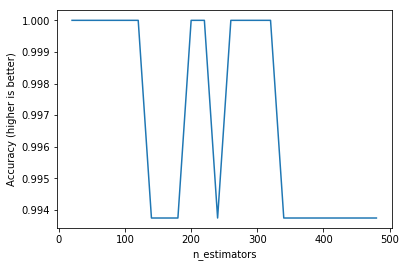

In [101]:
%matplotlib inline
# plot n_estimators (x-axis) versus Accuracy (y-axis)
plt.plot(estimator_range, acc_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy (higher is better)')
plt.show()

**n_estimators** should be a large enough value such that the error seems to be stable.

Now lets do the same thing with **max_features**:

In [103]:
# list of values to try for max_features
feature_range = range(1, len(X.columns.tolist())+1)

# list to store the average RMSE for each value of max_features
acc_scores = []

for feature in feature_range:
    rf = RandomForestClassifier(n_estimators=50, bootstrap=True, 
                                  oob_score=True, max_features=feature, random_state=1234)
    rf.fit(X_train,y_train)
    preds = rf.predict(X_test)
    rmse = accuracy_score(y_test,preds)
    acc_scores.append(rmse)

Text(0,0.5,'Accuracy (higher is better)')

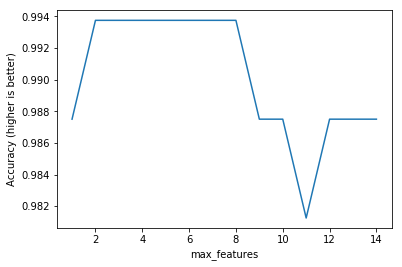

In [104]:
# plot max_features (x-axis) versus accuracy (y-axis)
plt.plot(feature_range, acc_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy (higher is better)')

So it looks like using all of the features is best. Let's build the optimal classifier we can given what we know and see the overall performance on the test set:

In [106]:
rf_best = RandomForestClassifier(n_estimators=50, max_features=3, bootstrap=True, oob_score=True, random_state=123)
rf_best.fit(X_train,y_train)
preds = rf_best.predict(X_test)
acc = accuracy_score(y_test,preds)
print("Best RMSE:",acc)

Best RMSE: 1.0


And lets take a look at the feature importances:

In [115]:
# compute feature importances
importances = pd.DataFrame({'feature':X_train.columns.tolist(),
                            'importance':rf_best.feature_importances_}
                          ).sort_values(by='importance',ascending=False)
importances

,feature,importance
10,hemo,0.242453
11,pcv,0.186366
7,sc,0.137230
2,sg,0.093366
3,al,0.068723
6,bu,0.065649
13,rc,0.065482
8,sod,0.035852
5,bgr,0.029528
1,bp,0.020230


Finally, if we take a look back at our 3d visualization, we can actually add probability contours to our random forest as opposed to simply using the original gridded values, visualizing on the top 3 numeric feature importances:

In [118]:
top_3_imps = importances.feature.head(3).values.tolist()
top_3_imps

['hemo', 'pcv', 'sc']

In [120]:
X_3dim_scaled = numeric_scaled[top_3_imps]

In [141]:
#generate the 3d mesh
plot_step = 0.5
x_min, x_max = X_3dim_scaled.values[:, 0].min() - .5, X_3dim_scaled.values[:, 0].max() + .5
y_min, y_max = X_3dim_scaled.values[:, 1].min() - .5, X_3dim_scaled.values[:, 1].max() + .5
z_min, z_max = X_3dim_scaled.values[:, 2].min() - .5, X_3dim_scaled.values[:, 2].max() + .5
xx, yy,zz = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step),
                        np.arange(z_min, z_max, plot_step))

rf_best = RandomForestClassifier(n_estimators=50, max_features=3, bootstrap=True, oob_score=True, random_state=123)
rf_best.fit(X_3dim_scaled,y)

#generate meshgrid predictions but dont reshape
probs = rf_best.predict_proba(np.c_[xx.ravel(), yy.ravel(),zz.ravel()])[:,1] #extract probability of class 1

#get and normalize colormap to range we have for our probabilities
cm = plt.get_cmap("coolwarm")
cNorm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

finalColors = scalarMap.to_rgba(probs)

<IPython.core.display.Javascript object>


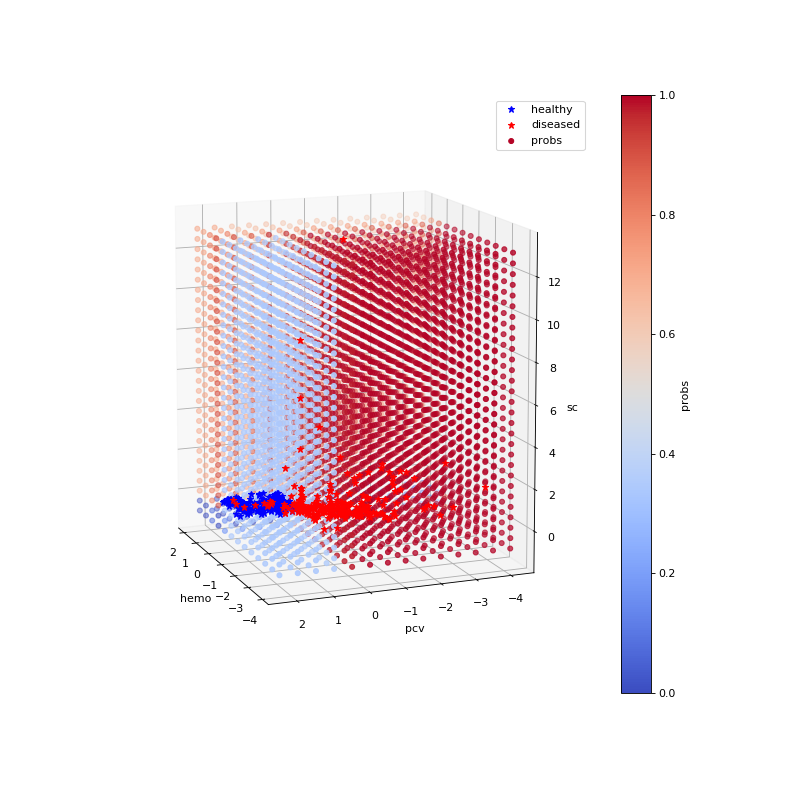

In [144]:
from matplotlib import colors
import matplotlib.cm as cmx
#make the 3d plot movable!
%matplotlib nbagg

# create figure
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')

#add the 2 classes individually
ax.plot3D(X_3dim_scaled.values[y.values==0,0], X_3dim_scaled.values[y.values==0,1], X_3dim_scaled.values[y.values==0,2],'*b',label="healthy")
ax.plot3D(X_3dim_scaled.values[y.values==1,0], X_3dim_scaled.values[y.values==1,1], X_3dim_scaled.values[y.values==1,2],'*r',label="diseased")
#add scatterplot of our probabilities
ax.scatter3D(xx,yy,zz,c=finalColors,label="probs")
scalarMap.set_array(probs)
fig.colorbar(scalarMap,label='probs')
#add axis labels and legend
ax.set_xlabel(top_3_imps[0])
ax.set_ylabel(top_3_imps[1])
ax.set_zlabel(top_3_imps[2])
ax.legend()
#must use this to render the plot to screen
plt.show()

#### Exercise Time
  * Build a Random Forest Classifier Model using all of the features, including the categoricals.
    * What is the test-set Accuracy?
    * What are the feature importances? Are they in a different ranked order than those for the compressive_strength model?

In [ ]:
pass

### Comparing Random Forests with Single Decision Trees

**Advantages of Random Forests:**
  * Performance is competitive with the best supervised learning methods
  - Provides a more reliable estimate of feature importance
  - Allows you to estimate out-of-sample error without using train/test split or cross-validation

**Disadvantages of Random Forests:**
  - Less interpretable
  - Slower to train
  - Slower to predict

### Comparing Ensembles to Individual Models
**Advantages of ensembling:**
  - Increases predictive accuracy
  - Easy to get started (especially with Random Forests)

**Disadvantages of ensembling:**
  - Decreases interpretability
  - Takes longer to train/predict
  - More complex to automate and maintain
  - Sometimes marginal gains in accuracy may not be worth the added complexity